In [1]:
import _pickle as pickle
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import timeit

from itertools import product

In [454]:
n_samples = np.floor(1 * (2 ** np.arange(6, 18)) ** 2)
n_context = 8

p_high = np.arange(1, 10, 2)
p_high = p_high / (p_high + 1)
p_high  = np.concatenate((p_high, np.array([0.99, 0.999])))

print(n_samples)
print(p_high)

[4.09600000e+03 1.63840000e+04 6.55360000e+04 2.62144000e+05
 1.04857600e+06 4.19430400e+06 1.67772160e+07 6.71088640e+07
 2.68435456e+08 1.07374182e+09 4.29496730e+09 1.71798692e+10]
[0.5        0.75       0.83333333 0.875      0.9        0.99
 0.999     ]


In [455]:
n_high = np.floor(n_samples[:, None] * p_high[None, :])
n_low = np.floor(n_samples[:, None] * (1 - p_high[None, :]))

In [472]:
iw_constant = 10
error_iw_high = iw_constant / np.sqrt(n_high)
error_iw_low = iw_constant / np.sqrt(n_low)

In [473]:
p_relevant_high = (n_context - 1) / n_context + p_high / n_context
p_relevant_low = (n_context - 1) / n_context + (1 - p_high) / n_context

n_relevant_high = np.floor(n_high * p_relevant_high)
n_relevant_low = np.floor(n_low * p_relevant_low)

In [474]:
p_relevant_low, p_relevant_high

(array([0.9375    , 0.90625   , 0.89583333, 0.890625  , 0.8875    ,
        0.87625   , 0.875125  ]),
 array([0.9375    , 0.96875   , 0.97916667, 0.984375  , 0.9875    ,
        0.99875   , 0.999875  ]))

In [475]:
ic_constant = 0.00001
error_ic_high = (1 - p_relevant_high) + ic_constant / np.sqrt(n_relevant_high)
error_ic_low = (1 - p_relevant_low) + ic_constant / np.clip(np.sqrt(n_relevant_low), a_min=1e-7, a_max=np.inf)

In [476]:
np.concatenate((error_ic_high.T[..., None], error_iw_high.T[..., None]), axis=-1)

array([[[6.25002282e-02, 2.20970869e-01],
        [6.25001141e-02, 1.10485435e-01],
        [6.25000571e-02, 5.52427173e-02],
        [6.25000285e-02, 2.76213586e-02],
        [6.25000143e-02, 1.38106793e-02],
        [6.25000071e-02, 6.90533966e-03],
        [6.25000036e-02, 3.45266983e-03],
        [6.25000018e-02, 1.72633492e-03],
        [6.25000009e-02, 8.63167458e-04],
        [6.25000004e-02, 4.31583729e-04],
        [6.25000002e-02, 2.15791864e-04],
        [6.25000001e-02, 1.07895932e-04]],

       [[3.12501833e-02, 1.80421959e-01],
        [3.12500917e-02, 9.02109796e-02],
        [3.12500458e-02, 4.51054898e-02],
        [3.12500229e-02, 2.25527449e-02],
        [3.12500115e-02, 1.12763724e-02],
        [3.12500057e-02, 5.63818622e-03],
        [3.12500029e-02, 2.81909311e-03],
        [3.12500014e-02, 1.40954656e-03],
        [3.12500007e-02, 7.04773278e-04],
        [3.12500004e-02, 3.52386639e-04],
        [3.12500002e-02, 1.76193319e-04],
        [3.12500001e-02, 8.80966

In [477]:
np.concatenate((error_ic_low.T[..., None], error_iw_low.T[..., None]), axis=-1)

array([[[6.25002282e-02, 2.20970869e-01],
        [6.25001141e-02, 1.10485435e-01],
        [6.25000571e-02, 5.52427173e-02],
        [6.25000285e-02, 2.76213586e-02],
        [6.25000143e-02, 1.38106793e-02],
        [6.25000071e-02, 6.90533966e-03],
        [6.25000036e-02, 3.45266983e-03],
        [6.25000018e-02, 1.72633492e-03],
        [6.25000009e-02, 8.63167458e-04],
        [6.25000004e-02, 4.31583729e-04],
        [6.25000002e-02, 2.15791864e-04],
        [6.25000001e-02, 1.07895932e-04]],

       [[9.37503283e-02, 3.12500000e-01],
        [9.37501641e-02, 1.56250000e-01],
        [9.37500821e-02, 7.81250000e-02],
        [9.37500410e-02, 3.90625000e-02],
        [9.37500205e-02, 1.95312500e-02],
        [9.37500103e-02, 9.76562500e-03],
        [9.37500051e-02, 4.88281250e-03],
        [9.37500026e-02, 2.44140625e-03],
        [9.37500013e-02, 1.22070312e-03],
        [9.37500006e-02, 6.10351562e-04],
        [9.37500003e-02, 3.05175781e-04],
        [9.37500002e-02, 1.52587

In [478]:
alpha_high = np.argmin(
    np.concatenate((error_ic_high[..., None], error_iw_high[..., None]), axis=-1),
    axis=-1
).T
alpha_low = np.argmin(
    np.concatenate((error_ic_low[..., None], error_iw_low[..., None]), axis=-1),
    axis=-1
).T

In [479]:
alpha_high

array([[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [480]:
alpha_low

array([[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]])

In [481]:
n_high[0]

array([2048., 3072., 3413., 3584., 3686., 4055., 4091.])

In [482]:
p_high

array([0.5       , 0.75      , 0.83333333, 0.875     , 0.9       ,
       0.99      , 0.999     ])

In [483]:
n_samples.shape

(12,)

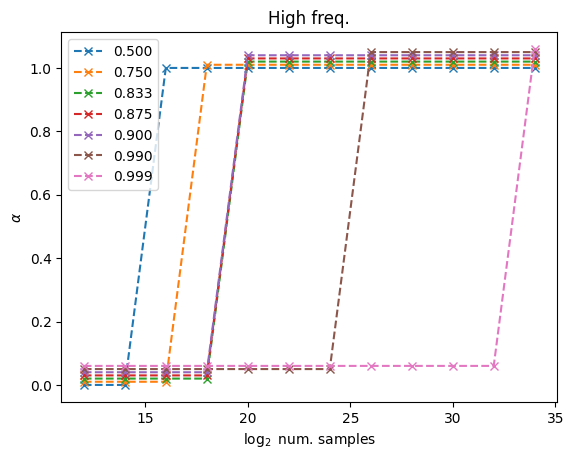

In [484]:
for p_high_i, curr_p_high in enumerate(p_high):
    plt.plot(
        np.log2(n_samples),
        alpha_high[p_high_i] + p_high_i * 0.01,
        label="{:.3f}".format(curr_p_high),
        marker="x",
        linestyle="--",
        alpha=1.0
    )

plt.title("High freq.")
plt.xlabel("$\\log_2$ num. samples")
plt.ylabel("$\\alpha$")
plt.legend()

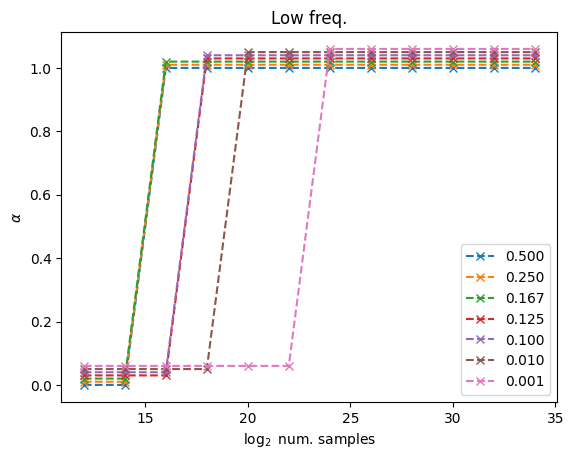

In [485]:
for p_low_i, curr_p_high in enumerate(p_high):
    plt.plot(
        np.log2(n_samples),
        alpha_low[p_low_i] + p_low_i * 0.01,
        label="{:.3f}".format(1 - curr_p_high),
        marker="x",
        linestyle="--",
        alpha=1.0
    )

plt.title("Low freq.")
plt.xlabel("$\\log_2$ num. samples")
plt.ylabel("$\\alpha$")
plt.legend()